# Experiment 3 Notebook

set up based on https://keras.io/examples/audio/ctc_asr/


In [1]:
# !pip install jiwer
# !pip install pandas
# !pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

import torch
device = torch.device("cpu")

from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


%matplotlib inline

2023-02-08 14:29:19.445371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 14:29:20.208706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ryanwhetten/anaconda3/envs/tf/lib/
2023-02-08 14:29:20.208778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ryanwhetten/anaconda3/envs/tf/lib/
2023-02-08 14:29:20.208785: W tensorflow/compi

for running downloading data from internet

In [3]:
# data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
# data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
# wavs_path = data_path + "/wavs/"
# metadata_path = data_path + "/metadata.csv"


# # Read metadata file and parse it
# metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
# metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
# metadata_df = metadata_df[["file_name", "normalized_transcription"]]
# metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
# metadata_df.head(3)


for loading data from computer

In [4]:
data_path = "/home/ryanwhetten/Downloads/LJSpeech-1.1"
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ025-0118,"and that, however diverse may be the fabrics o..."
1,LJ003-0163,"the misdemeanant tried or untried, the debtor ..."
2,LJ003-0170,"A Mr. Lundy, charged with forgery, was thus ac..."


In [5]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [6]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


2023-02-08 14:29:23.140352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 14:29:23.152187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 14:29:23.152425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 14:29:23.153069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from tensorflow.python.ops.gen_spectral_ops import fft
# int. scalar tensor. window length in samples
frame_length = 256
# int. scalar tensor. number of samples to step
frame_step = 160
# int scalar tensor. size of FFT
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float, this step might not be necessary
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, 
        frame_length=frame_length, 
        frame_step=frame_step, 
        fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


In [9]:
encode_single_sample(metadata_df.file_name[0], metadata_df.normalized_transcription[0])


(<tf.Tensor: shape=(1105, 193), dtype=float32, numpy=
 array([[ 0.1574844 ,  0.40428105,  0.42962363, ..., -0.961249  ,
         -0.9662072 , -0.9675628 ],
        [ 0.00450221,  0.575318  ,  0.9873249 , ..., -0.91963655,
         -0.9362741 , -0.9672159 ],
        [-0.44351074,  0.28148907,  0.8188127 , ..., -1.012881  ,
         -1.05065   , -1.0861028 ],
        ...,
        [ 1.9646229 ,  2.3540707 ,  2.550006  , ..., -1.0038054 ,
         -1.0093846 , -1.0228091 ],
        [ 1.0816412 ,  1.4285628 ,  1.4058588 , ..., -1.0215591 ,
         -1.0787656 , -1.1523682 ],
        [ 0.42314473,  2.1246405 ,  2.57983   , ..., -1.5804505 ,
         -1.5040886 , -1.5082053 ]], dtype=float32)>,
 <tf.Tensor: shape=(126,), dtype=int64, numpy=
 array([ 1, 14,  4, 30, 20,  8,  1, 20,  0, 30,  8, 15, 23,  5, 22,  5, 18,
        30,  4,  9, 22,  5, 18, 19,  5, 30, 13,  1, 25, 30,  2,  5, 30, 20,
         8,  5, 30,  6,  1,  2, 18,  9,  3, 19, 30, 15, 18, 30, 20,  9, 19,
        19, 21,  5, 19, 30, 

In [10]:
batch_size = 4

# define training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

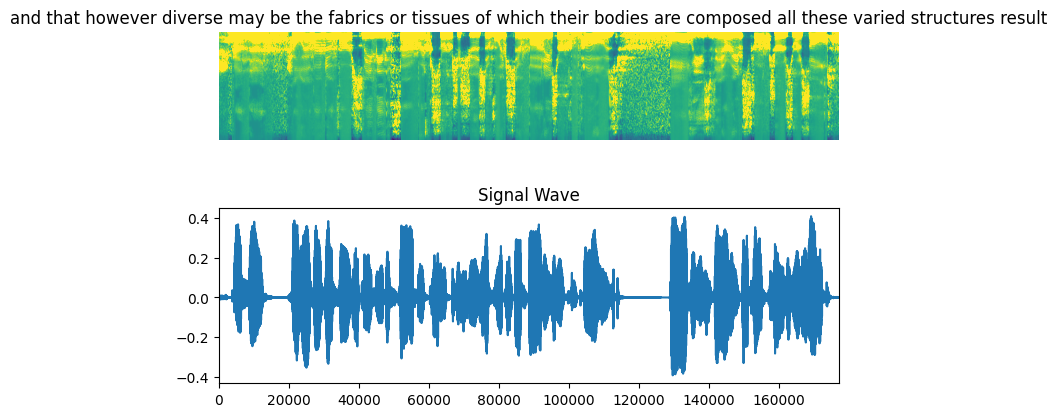

In [11]:
fig = plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

In [12]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [13]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# Play to figure out custom loss function

In [14]:
def get_cos_sim(s, s1, model=minilm):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)

In [15]:
def get_respective_cos_sim(s, s1, model=minilm):
    cos_sim = get_cos_sim(s, s1, model)
    return cos_sim.diagonal()

In [16]:
def relu(x):
    return np.maximum(0.000001,x)

In [17]:
test = np.array([-0.0550,  0.0071,  0.1290,  0.2937])
relu(test)

array([1.000e-06, 7.100e-03, 1.290e-01, 2.937e-01])

In [18]:
def get_cos_loss(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((4,1))
    return -np.log(cos_sim).numpy()

In [19]:
gt = []
for X, y in train_dataset:
#     print(num_to_char(y))
#     print(X)
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        print(label)
        gt.append(label)
    break

and that however diverse may be the fabrics or tissues of which their bodies are composed all these varied structures result
the misdemeanant tried or untried the debtor who wished to avoid the discomfort of the crowded debtors' side the outspoken newspaper editor
a mr lundy charged with forgery was thus accommodated on the state side for upwards of five years
why don't you make some money? poor guy was going out of his mind we told her she should not annoy him  poor guy he is doing his best don't annoy him so much


In [20]:
# batch_predictions = model.predict(X)

# batch_predictions = decode_batch_predictions(batch_predictions)

In [21]:
# batch_predictions.shape

In [22]:
# batch_pred_decode = decode_batch_predictions(batch_predictions)

In [23]:
# batch_pred_decode

In [24]:
# get_cos_sim(gt, batch_pred_decode)
# minilm.encode('hi', convert_to_tensor=True)

In [25]:
# 1 - get_cos_sim(gt[0:2], batch_pred_decode[0:2])


Playing around w/get batches of cosine similarities

In [26]:
get_cos_sim(gt, gt)


tensor([[ 1.0000, -0.0034, -0.0511, -0.2040],
        [-0.0034,  1.0000,  0.1276,  0.2089],
        [-0.0511,  0.1276,  1.0000,  0.0154],
        [-0.2040,  0.2089,  0.0154,  1.0000]])

In [27]:
gt_sim = [
    'promptly closed three days later for some random reasons by the renters',
    'but reformation was soley skin deep under the surface many of the old evils still rankled',
    'he read the letter but refused to believe that it was sincere even though his wife afirmed to him that it was',
    'they entered a stone cold room and were presently joined by the prisoner',
]

In [28]:
get_cos_sim(gt, gt_sim)


tensor([[-0.0988,  0.0753, -0.0541, -0.0004],
        [ 0.1647,  0.0324,  0.2349,  0.1094],
        [ 0.1800,  0.2237,  0.1914,  0.1139],
        [ 0.0561, -0.0881,  0.2511, -0.0709]])

In [29]:
get_cos_sim(gt, gt_sim).diagonal()

# (1-get_cos_sim(gt, batch_pred_decode).diagonal()).mean()

tensor([-0.0988,  0.0324,  0.1914, -0.0709])

In [30]:
def get_labels(y):
    gt = []
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    return gt

In [31]:
get_labels(y)

['and that however diverse may be the fabrics or tissues of which their bodies are composed all these varied structures result',
 "the misdemeanant tried or untried the debtor who wished to avoid the discomfort of the crowded debtors' side the outspoken newspaper editor",
 'a mr lundy charged with forgery was thus accommodated on the state side for upwards of five years',
 "why don't you make some money? poor guy was going out of his mind we told her she should not annoy him  poor guy he is doing his best don't annoy him so much"]

In [32]:
def CTC_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + cos_loss

In [47]:
batch_predictions = model_base(X)
batch_predictions_decoded = decode_batch_predictions(batch_predictions)
batch_predictions_decoded
# batch_predictions = model.predict(X)

# batch_predictions = decode_batch_predictions(batch_predictions)

2023-02-08 14:27:28.803573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-08 14:27:30.245443: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-08 14:27:30.919930: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


['gvpyiyvgipiaiavivaipivpiaygviavagaipiaiavioigviotb',
 'iayviapipipaiaipiapiaiaiaoaiavioaiaiaipaiaiaipipipihiaia!h',
 'rpvagivgivaivaiapiaia!gviaiavapiovgipaipaiaiaiaia!aihbcb',
 'r!ivay!gaipia!avaiavgvaiavaiaiaivaia!gviaiaiaiphavaipavtit']

In [48]:
get_labels(y)

["stated the president's views of his responsibilities with simplicity and clarity quote",
 'and went on to say i do assure you madam that it shall be the anxious endeavor of my life to promote her happiness by every means in my power',
 'based on his experience of them in western australia he not only thought them likely to be more deterrent',
 'two sailors charles palm and sam tilling were hanged at the same place for the murder of their captain james keith']

In [49]:
CTCLoss(y, batch_predictions)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1649.0596],
       [1625.361 ],
       [1642.8562],
       [1635.9003]], dtype=float32)>

In [50]:
CTC_Cosine_Loss(y, batch_predictions)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1650.8082],
       [1626.7214],
       [1649.2225],
       [1649.7158]], dtype=float32)>

## Model

In [33]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, loss=CTCLoss):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=loss, run_eagerly=True)
#     model.compile(optimizer=opt, loss=loss)
    
    return model




In [34]:
model_base = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTCLoss,
)

In [46]:
model_cos = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTC_Cosine_Loss,
    
)

In [47]:
model_cos.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

In [ ]:
# # get model
# model_base = build_model(
#     input_dim=fft_length // 2 + 1,
#     output_dim=char_to_num.vocabulary_size(),
#     rnn_units=512,
#     loss=CTCLoss
# )
# model_base.summary(line_length=110)

In [49]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
#         avg_cos_dis = get_avg_cos_dis(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
#         print(f"Avg. Cos Dis: {avg_cos_dis:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
#             print(f"Avg. Cos Dis: {get_avg_cos_dis(targets[i], predictions[i]):.4f}")
            print("-" * 100)
            
            

Run Model

In [53]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_base.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

 123/2948 [>.............................] - ETA: 2:18:58 - loss: 324.0783


KeyboardInterrupt



In [52]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval_Cos(validation_dataset)
# Train the model
history_cos = model_cos.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[CallbackEval_Cos],
)

TypeError: set_model() missing 1 required positional argument: 'model'

In [41]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model_base.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
    break
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 [==============================] - 0s 229ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : its receipt was immediately followed by the promulgation of its contents to the persons most closely concerned
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : its receipt was immediately followed by the promulgation of its contents to the persons most closely concerned
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the second test run required one minute and fifteen seconds
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the second test run required one minute and fifte

In [ ]:
tf.strings.reduce_join(num_to_char([1, 2, 3])).numpy().decode("utf-8")

In [ ]:
decode_batch_predictions(b)

In [ ]:
a = np.array([
    [[1],[1],[1]], 
    [[2],[2],[2]], 
    [[3],[3],[3]]
])
b = tf.constant(a, dtype="int64")
b

In [ ]:
tf.compat.v1.transpose(b, perm=[1,0])

In [ ]:
tf.compat.v1.transpose(b, perm=[0,1])